In [1]:
# =============================
# 1. Import Libraries
# =============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



In [3]:
# =============================
# 2. Load Data
# =============================
train = pd.read_csv("C:/Users/Shugaba/dsn2025/data/train.csv")
test = pd.read_csv("C:/Users/Shugaba/dsn2025/data/test.csv")
original = pd.read_csv("C:/Users/Shugaba/dsn2025/data/used_cars.csv")  

print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Original shape:", original.shape)

train.head()

Train shape: (188533, 13)
Test shape: (125690, 12)
Original shape: (4009, 12)


id          brand              model  model_year  milage      fuel_type  \
0   0           MINI      Cooper S Base        2007  213000       Gasoline   
1   1        Lincoln              LS V8        2002  143250       Gasoline   
2   2      Chevrolet  Silverado 2500 LT        2002  136731  E85 Flex Fuel   
3   3        Genesis   G90 5.0 Ultimate        2017   19500       Gasoline   
4   4  Mercedes-Benz        Metris Base        2021    7388       Gasoline   

                                              engine  \
0       172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel   
1       252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel   
2  320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
3       420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4       208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                     transmission ext_col int_col  \
0                             A/T  Yellow    Gray   
1                             A/T  Silver   Beige   
2                             A/T    Blue    Gray   
3  Transmission w/Dual Shift Mode   Black   Black   
4                     7-Speed A/T   Black   Beige   

                                 accident clean_title  price  
0                           None reported         Yes   4200  
1  At least 1 accident or damage reported         Yes   4999  
2                           None reported         Yes  13900  
3                           None reported         Yes  45000  
4                           None reported         Yes  97500

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64


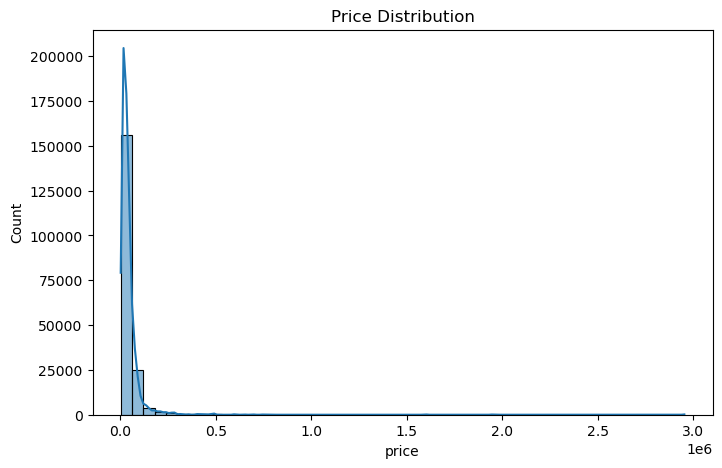

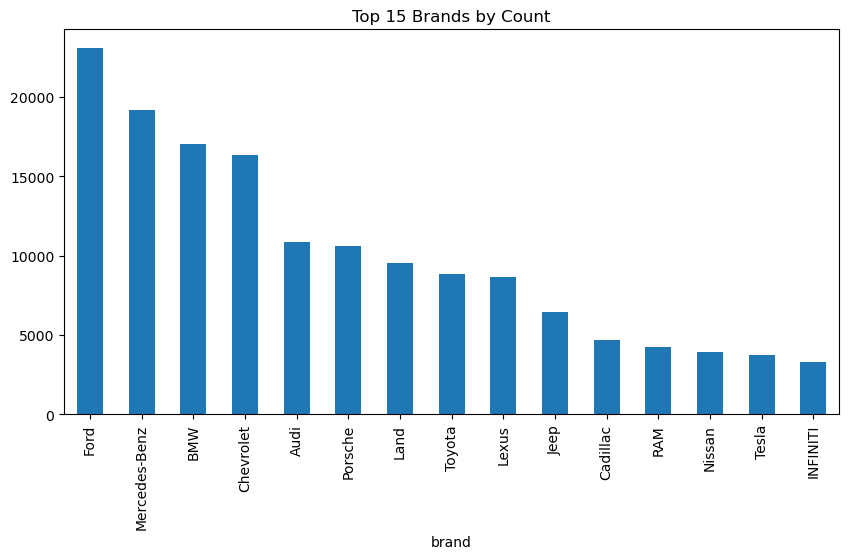

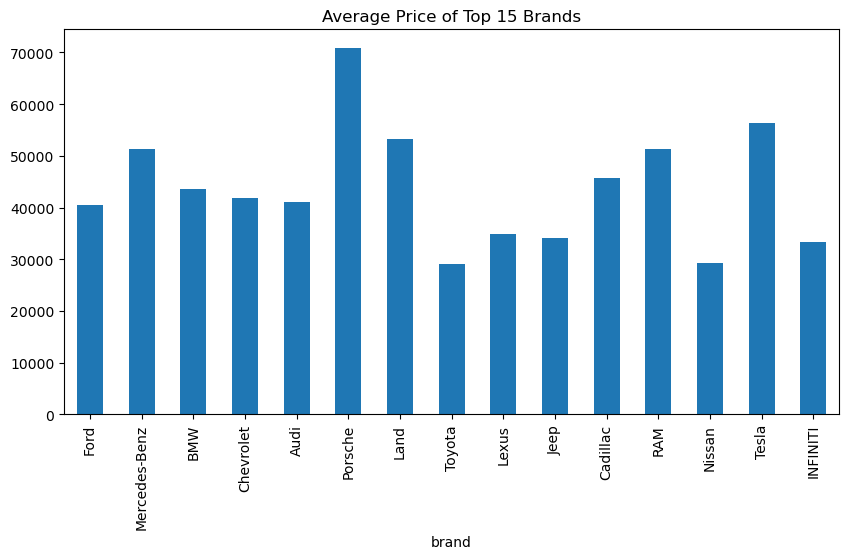

In [6]:
# =============================
# 3. Exploratory Data Analysis (EDA)
# =============================

# Check missing values
print(train.isnull().sum())

# Target variable distribution
plt.figure(figsize=(8,5))
sns.histplot(train['price'], bins=50, kde=True)
plt.title("Price Distribution")
plt.show()

# Example: Top 15 brands by count
top_brands = train['brand'].value_counts().head(15)
top_brands.plot(kind="bar", figsize=(10,5), title="Top 15 Brands by Count")
plt.show()

# Example: Average price per brand (top 15 by count)
avg_brand_price = train.groupby("brand")['price'].mean().loc[top_brands.index]
avg_brand_price.plot(kind="bar", figsize=(10,5), title="Average Price of Top 15 Brands")
plt.show()


In [9]:
# =============================
# 4. Data Cleaning Function
# =============================

def clean_data(df, is_train=True):
    df = df.copy()

    # --- Price ---
    if 'price' in df.columns:
        if df['price'].dtype == 'object':
            df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)

    # --- Mileage ---
    if 'milage' in df.columns:  # keep 'milage' if that's what your dataset uses
        if df['milage'].dtype == 'object':
            df['milage'] = df['milage'].str.replace('[, mi.]', '', regex=True)
            df['milage'] = pd.to_numeric(df['milage'], errors='coerce')

    # --- Model Year ---
    if 'model_year' in df.columns:
        df['model_year'] = pd.to_numeric(df['model_year'], errors='coerce')

    # --- Engine: extract HP and liters ---
    if 'engine' in df.columns:
        if df['engine'].dtype == 'object':
            df['engine_hp'] = df['engine'].str.extract(r'(\d+\.?\d*)HP')
            df['engine_hp'] = pd.to_numeric(df['engine_hp'], errors='coerce')

            df['engine_size'] = df['engine'].str.extract(r'(\d+\.?\d*)L')
            df['engine_size'] = pd.to_numeric(df['engine_size'], errors='coerce')
        else:
            df['engine_hp'] = np.nan
            df['engine_size'] = np.nan

    # --- Accident History ---
    if 'accident' in df.columns:
        df['accident'] = df['accident'].apply(lambda x: 0 if pd.isna(x) or 'None' in str(x) else 1)

    # --- Clean Title ---
    if 'clean_title' in df.columns:
        df['clean_title'] = df['clean_title'].map({"Yes": 1, "No": 0})
        df['clean_title'] = df['clean_title'].fillna(0)  # or 1 depending on domain knowledge

    # --- Car Age ---
    if 'model_year' in df.columns:
        df['car_age'] = 2025 - df['model_year']

    return df


In [10]:
# =============================
# 5. Apply Cleaning
# =============================
train_clean = clean_data(train)
test_clean = clean_data(test, is_train=False)

print(train_clean.head())

   id          brand              model  model_year  milage      fuel_type  \
0   0           MINI      Cooper S Base        2007  213000       Gasoline   
1   1        Lincoln              LS V8        2002  143250       Gasoline   
2   2      Chevrolet  Silverado 2500 LT        2002  136731  E85 Flex Fuel   
3   3        Genesis   G90 5.0 Ultimate        2017   19500       Gasoline   
4   4  Mercedes-Benz        Metris Base        2021    7388       Gasoline   

                                              engine  \
0       172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel   
1       252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel   
2  320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
3       420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4       208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                     transmission ext_col int_col  accident  clean_title  \
0                             A/T  Yellow    Gray         0          1.0   
1                             A/T  Silver 

In [11]:
# =============================
# 6. Feature Selection
# =============================

# Features to use
features = ['brand', 'model_year', 'milage', 'fuel_type',
            'engine_hp', 'engine_size', 'transmission',
            'accident', 'clean_title', 'car_age']

X = train_clean[features]
y = train_clean['price']

X_test_final = test_clean[features]

In [14]:
from sklearn.impute import SimpleImputer

# Numerical and categorical columns
num_features = ['model_year', 'milage', 'engine_hp', 'engine_size', 'car_age']
cat_features = ['brand', 'fuel_type', 'transmission']

# Transformers with Imputation
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),   # fill NaN with median
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # fill NaN with mode
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features)
    ]
)



In [15]:
# =============================
# 8. Baseline Model (Linear Regression)
# =============================

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# Train-test split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_valid)

rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print("Validation RMSE (Linear Regression):", rmse)


Validation RMSE (Linear Regression): 69443.62409460385


In [16]:
# =============================
# 9. Final Training on Full Data
# =============================
model.fit(X, y)
preds = model.predict(X_test_final)

In [17]:
# =============================
# 10. Submission File
# =============================

submission = pd.DataFrame({
    "id": test["id"],
    "price": preds
})

submission.to_csv("usedcar_submission.csv", index=False)
print("Submission file created!")


Submission file created!


In [18]:
# =============================
# 11. Model Comparison
# =============================
from sklearn.linear_model import Ridge, Lasso
from xgboost import XGBRegressor

models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001, max_iter=5000),
    "XGBoost": XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
}

results = {}

for name, reg in models.items():
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("regressor", reg)
    ])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    results[name] = rmse
    print(f"{name} RMSE: {rmse:.2f}")

Linear Regression RMSE: 69443.62
Ridge RMSE: 69443.53


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 141051476413891.0, tolerance: 96156439944.78264
  model = cd_fast.sparse_enet_coordinate_descent(


Lasso RMSE: 69443.21
XGBoost RMSE: 71487.99


In [19]:
# =============================
# 12. Pick Best Model
# =============================
best_model_name = min(results, key=results.get)
print("Best model is:", best_model_name, "with RMSE:", results[best_model_name])

# Retrain best model on full dataset
best_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", models[best_model_name])
])

best_model.fit(X, y)
final_preds = best_model.predict(X_test_final)

Best model is: Lasso with RMSE: 69443.20659018132


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 131701682147823.5, tolerance: 117125827171.4387
  model = cd_fast.sparse_enet_coordinate_descent(


In [20]:
# Create final submission file
submission = pd.DataFrame({
    "id": test["id"],
    "price": final_preds
})

submission.to_csv("dsn25_usedcar_submission.csv", index=False)
print("Final submission saved as dsn25_usedcar_submission.csv")

Final submission saved as dsn25_usedcar_submission.csv


In [21]:
# Preview first few rows
print("\nPreview of submission file:")
print(submission.head())


Preview of submission file:
       id         price
0  188533  21753.223672
1  188534  68994.389843
2  188535  66753.828591
3  188536  42905.743853
4  188537  34191.229129
